In [5]:
import scipy

ModuleNotFoundError: No module named 'scipy'

In [ ]:
!pip3 install scipy

  Using cached https://files.pythonhosted.org/packages/0a/2e/44795c6398e24e45fa0bb61c3e98de1cfea567b1b51efd3751e2f7ff9720/scipy-1.9.3.tar.gz
  Installing build dependencies ... done


In [ ]:
print(1)

In [1]:
import math
import unittest

import QuantLib as ql
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import brentq, curve_fit, least_squares
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

from scipy.stats import norm

from math import log, exp, sqrt
import plotly.express as px

ModuleNotFoundError: No module named 'QuantLib'

In [4]:
# !python3 --version

In [30]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import plotly.graph_objs as go
import time

In [31]:
SABRbeta = 0.5
r = 0.05



In [32]:
def call(S, K, T, sigma):
    F = S / (math.exp(- r * T))
    d1 = (math.log(F / K) + 0.5 * sigma**2 * T) / (sigma * math.sqrt(T))
    d2 = (math.log(F / K) - 0.5 * sigma**2 * T) / (sigma * math.sqrt(T))
    res = math.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    return res
    
    
# the implied volatility according the SABR model
def SABRsigma(S, K, T, r, alpha, beta, rho, nu):
    X = K
    F = S / (math.exp(- r * T))
    if F is K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F*(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

def SABRcall(S, K, T, alpha, beta, rho, nu):
    return call(S, K, T, SABRsigma(S, K, T, alpha, beta, rho, nu))

def call_by_sigma(S, K, T, sigma):
    return call(S, K, T, sigma)

covariance matrix:
 [[ 1.  -0.7]
 [-0.7  1. ]] 
----------------


Text(0.5, 1.0, 'Correlated Random Variables')

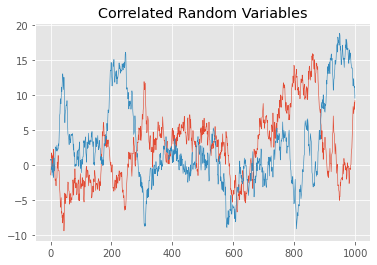

In [33]:
rho = -0.7
Ndraws = 1000


mu = np.array([0,0])
cov = np.array([[1, rho] , [rho , 1]])
print('covariance matrix:\n', cov, "\n----------------")

W = np.random.multivariate_normal(mu, cov, size=Ndraws)

plt.plot(W.cumsum(axis=0));
plt.title('Correlated Random Variables')

In [34]:
# checking the realized covariance
print(np.corrcoef(W.T))

[[ 1.         -0.69122559]
 [-0.69122559  1.        ]]


In [35]:

def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=paths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])

        prices[:, t] = S_t
        sigs[:, t] = v_t
#         paths_S_t.append(S_t)
    
    if return_vol:
        return prices, sigs
    
    return prices

In [54]:
kappa =10
theta = 0.1
v_0 =  0.2
xi = 0.9
r = 0.02
S = 100
paths =100
steps = 200
T = 1

In [55]:
heston_prices_pos = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-0.6, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)

In [56]:
heston_prices_pos

array([[ 97.48366862,  98.12618035,  93.41244694, ...,  57.95247084,
         58.11776278,  59.37755186],
       [100.46332739, 103.18700138, 109.28996588, ..., 106.87169424,
        106.52681498, 106.06521148],
       [100.48634112, 100.94232153,  96.26681504, ...,  79.02445862,
         81.61028389,  78.93051015],
       ...,
       [104.73293169, 109.38143659, 107.21577053, ..., 137.32314878,
        136.92218305, 140.16210394],
       [ 98.0963882 ,  97.68446408,  92.58732321, ..., 122.81110713,
        123.74731289, 121.33012393],
       [ 97.98608945, 103.10861422, 100.57410918, ..., 153.13884725,
        156.06277345, 157.53086199]])

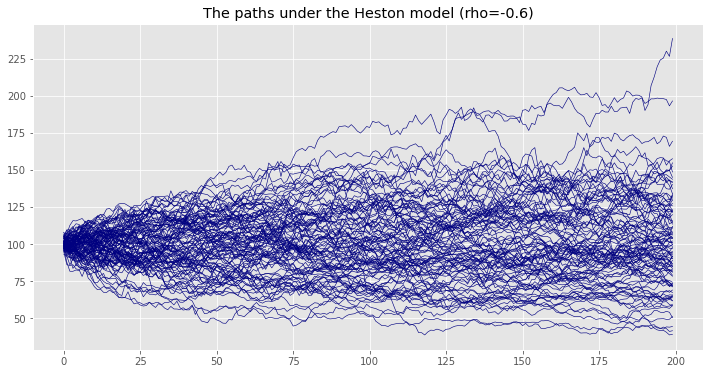

In [57]:
# %matplotlib inline
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 1))))

all_paths = []
Range = np.arange(steps) 

plt.title("The paths under the Heston model (rho=-0.6)")


for i in range(0, paths):
    ax.plot(Range, heston_prices_pos[i])



In [58]:

def generate_SABR_paths(S, T, r, alpha, beta, rho, nu,
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    alpha_t = alpha
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        S_t = S_t + alpha_t * (S_t)**beta * WT[:, 0]
        alpha_t = alpha_t + nu*alpha_t * WT[:, 1]

        prices[:, t] = S_t
        sigs[:, t] = alpha_t
    
    if return_vol:
        return prices, sigs
    
    return prices

In [64]:
S = 100
paths =100
steps = 200
T = 1

SABR_prices_pos = generate_SABR_paths(S, T, r=0, alpha=7, beta=0.36, rho=0.5, nu=0.3,
                          steps=steps, Npaths=paths, return_vol=False)

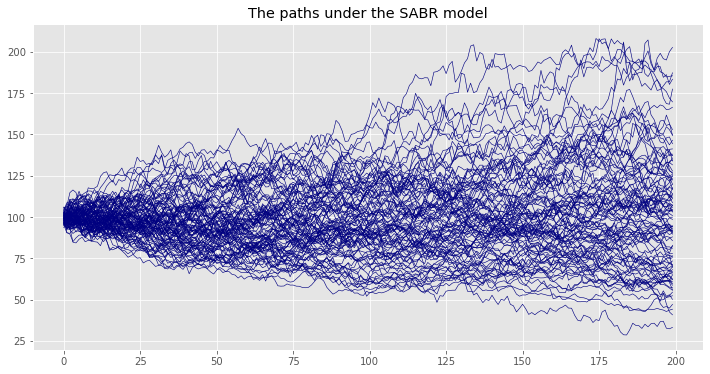

In [69]:
# %matplotlib inline
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 1))))

all_paths = []
Range = np.arange(steps) 

plt.title("The paths under the SABR model")


for i in range(0, paths):
    ax.plot(Range, SABR_prices_pos[i])



In [70]:
import sympy as sp
import sympy.stats

In [76]:
def sp_SABRsigma(F, K, T, alpha, beta, rho, nu):
    X = K
    z=(nu/alpha)*((F*K)**(0.5*(1-beta)))*sp.log(F/K)
    zhi = sp.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
    numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*K)**(1 - beta)))
    numer2 = 0.25*rho*beta*nu*alpha/((F*K)**((1 - beta)/2))
    numer3 = ((2 - 3*rho*rho)/24)*nu*nu
    numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
    denom1 = ((1 - beta)**2/24)*(sp.log(F/K))**2
    denom2 = (((1 - beta)**4)/1920)*((sp.log(F/K))**4)
    denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
    sabrsigma = numer/denom
    return sabrsigma

def sp_call(F, K, T, sigma):
#     F = S / (math.exp(- r * T))
    d1 = (sp.log(F / K) + 0.5 * sigma**2 * T) / (sigma * sp.sqrt(T))
    d2 = (sp.log(F / K) - 0.5 * sigma**2 * T) / (sigma * sp.sqrt(T))
    res = sp.exp(-r * T) * (F * sp.stats.cdf(n)(d1) - K * sp.stats.cdf(n)(d2))
    return res

def sp_sabrcall(F, K, T, alpha, beta, rho, nu):
    sigma = sp_SABRsigma(F, K, T, alpha, beta, rho, nu)
    d1 = (sp.log(F / K) + 0.5 * sigma**2 * T) / (sigma * sp.sqrt(T))
    d2 = (sp.log(F / K) - 0.5 * sigma**2 * T) / (sigma * sp.sqrt(T))
    res = sp.exp(-r * T) * (F * sp.stats.cdf(n)(d1) - K * sp.stats.cdf(n)(d2))
    return res

In [72]:
F, K, T, alpha, beta, rho, nu, sigma, n = sp.symbols('F K T alpha beta rho nu sigma n')

In [73]:
n = sympy.stats.Normal('n', 0, 1)
sp.stats.cdf(n)(1.96).evalf()

0.975002104851780

### Comparison of the BS and SABR delta

In [206]:
r = 0

In [207]:
sp_SABR_call = sp_sabrcall(F, K, T, alpha, beta, rho, nu)

dc_df = sp_SABR_call.diff(F) # this is SABR delta because this is the full derivative (not partial)

In [228]:
params1 = {'alpha': 7, 'beta': 0.36, 'rho': 0.5, 'nu': 0.3, 'K':100, 'F':110, 'T':0.2}

print(params1)

{'alpha': 7, 'beta': 0.36, 'rho': 0.5, 'nu': 0.3, 'K': 100, 'F': 110, 'T': 0.2}


In [211]:
# the formula of SABR delta (but it computes this way too long):

# WARNING! in the string below it implies that all derivatives are partial derivatives. 

# SABR_delta = dc_df + dc_dsigma * dsigma_df 


In [302]:
sabr_delta = dc_df.evalf(subs=params1)

print("SABR delta:", sabr_delta)

SABR delta: 0.727817442642211


In [303]:
bs_delta = (sp_call(F, K, T, sigma).diff(F)).evalf(subs=params2)
print("BS delta:", bs_delta)

BS delta: 0.756016733378073


In [304]:
print('divergence:', sabr_delta - bs_delta)

divergence: -0.0281992907358618


In [305]:
# checking result above
# (sp.exp(-r * T)*sp.stats.cdf(n)(((sp.log(F / K) + 0.5 * sigma**2 * T) / (sigma * sp.sqrt(T))))).evalf(subs=params2)

## Comparison of finite differences and explicit computing through formula

In [306]:
r = 0

In [307]:
shift = 1.001

params1 = {'alpha': 7, 'beta': 0.36, 'rho': 0.5, 'nu': 0.3, 'K':100, 'F':110, 'T':0.2}
params2 = {'alpha': 7, 'beta': 0.36, 'rho': 0.5, 'nu': 0.3, 'K':100, 'F':params1["F"]*shift, 'T':0.2}

print(params2)

{'alpha': 7, 'beta': 0.36, 'rho': 0.5, 'nu': 0.3, 'K': 100, 'F': 110.10999999999999, 'T': 0.2}


In [308]:
params1['sigma'] = sp_SABRsigma(F, K, T, alpha, beta, rho, nu).evalf(subs=params1)
print(params1)

params2['sigma'] = sp_SABRsigma(F, K, T, alpha, beta, rho, nu).evalf(subs=params2)
print(params2)


{'alpha': 7, 'beta': 0.36, 'rho': 0.5, 'nu': 0.3, 'K': 100, 'F': 110, 'T': 0.2, 'sigma': 0.350195305764570}
{'alpha': 7, 'beta': 0.36, 'rho': 0.5, 'nu': 0.3, 'K': 100, 'F': 110.10999999999999, 'T': 0.2, 'sigma': 0.350010207344147}


In [309]:
fin_diffces_sabr_delta = (sp_sabrcall(F, K, T, alpha, beta, rho, nu).evalf(subs=params2) - sp_sabrcall(F, K, T, alpha, beta, rho, nu).evalf(subs=params1)) / (shift - 1) / params1['F']

print('finite differences sabr delta:', fin_diffces_sabr_delta)

print('right sabr delta:', sabr_delta)
print('----------------------')

print('relative divergence:', str(((fin_diffces_sabr_delta/sabr_delta) - 1) * 100)[:8] + "%")


finite differences sabr delta: 0.728932370265217
right sabr delta: 0.727817442642211
----------------------
relative divergence: 0.153187%
